# Per PMID comparison of SemmedDB, M2C, and both relationships

This notebook creates individual networks for each PMID to display relationships pulled from Mark2Cure, SemmedDB, or both.

## Import modules and data

In [1]:
import pandas
import matplotlib
from matplotlib import pyplot as mplot
import networkx as nx
##Note, this needs networkx 2.2.3 to work
from pandas import read_csv

Import the relationship annotations data and semmedDB data from the SemmedDB comparison

In [2]:
savepath = 'data/'
exppath = 'exports/'
constrained_semmed_mesh = pandas.read_csv(exppath+'constrained_semmed_mesh.txt', delimiter='\t', header=0)
majority_result = pandas.read_csv(exppath+'majority_result.txt', delimiter='\t', header=0)
M2C_semmed_all_merge = pandas.read_csv(exppath+'M2C_semmed_all_merge.txt', delimiter='\t', header=0)

### drop unneed ex-index columns
constrained_semmed_mesh.drop('Unnamed: 0', axis=1, inplace=True)
majority_result.drop('Unnamed: 0', axis=1, inplace=True)
M2C_semmed_all_merge.drop('Unnamed: 0', axis=1, inplace=True)

print(constrained_semmed_mesh.head(n=2))

  SUBJECT_NAME      PREDICATE           OBJECT_NAME     PMID SUBJECT_CUI  \
0     Alacrima  COEXISTS_WITH  Multisystem disorder  4075537    C0344505   
1     Alacrima  COEXISTS_WITH  Multisystem disorder  4075537    C0344505   

  SUBJECT_SEMTYPE OBJECT_CUI OBJECT_SEMTYPE  PREDICATION_ID  SENTENCE_ID  \
0            cgab   C0559758           dsyn        11447727     21333667   
1            cgab   C0559758           dsyn        11447727     21333667   

   SUBJECT_NOVELTY  OBJECT_NOVELTY SUBJECT_M2C_TYPE OBJECT_M2C_TYPE  \
0                1               0          disease         disease   
1                1               0          disease         disease   

  SUBJECT_ID OBJECT_ID  
0    C562827   D004194  
1    C562827   D019578  


In [3]:
constrained_pmids = constrained_semmed_mesh['PMID'].unique().tolist()

In [5]:
edge_colors = {'m2c_only_edge': '#666666', 'sem_only_edge':'#cccccc','both_edge':'#333333','c_1_broken':'#ffff99'}
only_m2c_colors = {'c':'#ff00ff','d':'#31a6ff','g':'#00ff00'}
only_sem_colors = {'c':'#ffccff','d':'#c6e2ff','g':'#d3ffce'}
both_colors = {'c':'#990099','d':'#3b5998','g':'#003300'}

f = mplot.figure(figsize=(20,40))
i=0
while i<len(constrained_pmids):
    xrow = 0
    while xrow < 8:
        ycol = 0
        while ycol < 5:
            ##Color the Edges
            tmpdf = M2C_semmed_all_merge.loc[M2C_semmed_all_merge['PMID']==constrained_pmids[i]].copy()

            only_m2c_edges = tmpdf[['refid1','refid2','evtype']].loc[(tmpdf['SUBJECT_SEMTYPE']=='not found')&(tmpdf['OBJECT_SEMTYPE']=='not found')]
            only_m2c_edges.rename(columns={'refid1':'from','refid2':'to','evtype':'relation'}, inplace=True)
            only_m2c_edges['relcolor']= edge_colors['m2c_only_edge']
            only_m2c_edges['relcolor'].loc[(only_m2c_edges['relation']=='c_1_broken')|(only_m2c_edges['relation']=='c_2_broken')] = edge_colors['c_1_broken']

            only_sem_edges = tmpdf[['SUBJECT_ID','OBJECT_ID','PREDICATE']].loc[(tmpdf['refid1']=='not found')&
                                                                                        (tmpdf['refid2']=='not found')]
            only_sem_edges.rename(columns={'SUBJECT_ID':'from','OBJECT_ID':'to','PREDICATE':'relation'}, inplace=True)
            only_sem_edges['relcolor']= edge_colors['sem_only_edge']

            both_edges = tmpdf[['SUBJECT_ID','OBJECT_ID','PREDICATE']].loc[(tmpdf['refid1']!='not found')&
                                                                                    (tmpdf['refid2']!='not found')&
                                                                                    (tmpdf['SUBJECT_ID']!='not found')&
                                                                                    (tmpdf['OBJECT_ID']!='not found')]
            both_edges.rename(columns={'SUBJECT_ID':'from','OBJECT_ID':'to','PREDICATE':'relation'}, inplace=True)
            both_edges['relcolor']= edge_colors['both_edge']

            tmprels = [only_m2c_edges, only_sem_edges, both_edges]
            tmpset = []
            for eachreltable in tmprels:
                tmpset.append(eachreltable)
            reltable = pandas.concat(tmpset)
            reltable.drop_duplicates(subset=['from','to','relation'],keep='first',inplace=True)

            ##Color the Nodes
            m2c_n1 = tmpdf[['refid1','refid1_type']].loc[tmpdf['SUBJECT_SEMTYPE']=='not found']
            m2c_n1.rename(columns={'refid1':'node', 'refid1_type':'color'}, inplace=True)
            m2c_n2 = tmpdf[['refid2','refid2_type']].loc[tmpdf['OBJECT_SEMTYPE']=='not found']
            m2c_n2.rename(columns={'refid2':'node','refid2_type':'color'}, inplace=True)
            m2c_node = pandas.concat((m2c_n1,m2c_n2))
            m2c_node.drop_duplicates(subset='node',keep='first',inplace=True)

            sem_n1 = tmpdf[['SUBJECT_ID','SUBJECT_M2C_TYPE']].loc[tmpdf['refid1']=='not found']
            sem_n1.rename(columns={'SUBJECT_ID':'node', 'SUBJECT_M2C_TYPE':'color'}, inplace=True)
            sem_n2 = tmpdf[['OBJECT_ID','OBJECT_M2C_TYPE']].loc[tmpdf['refid2']=='not found']
            sem_n2.rename(columns={'OBJECT_ID':'node','OBJECT_M2C_TYPE':'color'}, inplace=True)
            sem_node = pandas.concat((sem_n1,sem_n2))
            sem_node.drop_duplicates(subset='node',keep='first',inplace=True)

            both_n1 = tmpdf[['SUBJECT_ID','SUBJECT_M2C_TYPE']].loc[(tmpdf['refid1']!='not found')&(tmpdf['SUBJECT_SEMTYPE']!='not found')]
            both_n1.rename(columns={'SUBJECT_ID':'node', 'SUBJECT_M2C_TYPE':'color'}, inplace=True)
            both_n2 = tmpdf[['OBJECT_ID','OBJECT_M2C_TYPE']].loc[(tmpdf['refid2']!='not found')&(tmpdf['OBJECT_SEMTYPE']!='not found')]
            both_n2.rename(columns={'OBJECT_ID':'node', 'OBJECT_M2C_TYPE':'color'}, inplace=True)
            both_node = pandas.concat((both_n1,both_n2))
            both_node.drop_duplicates(subset='node',keep='first',inplace=True)

            both_check = m2c_node.loc[m2c_node['node'].isin(sem_node['node'].tolist())]
            only_m2c_node = m2c_node.loc[~m2c_node['node'].isin(sem_node['node'].tolist())]
            only_sem_node = sem_node.loc[~sem_node['node'].isin(m2c_node['node'].tolist())]

            only_m2c_node.color.replace(only_m2c_colors, inplace=True)
            only_sem_node.color.replace(only_sem_colors, inplace=True)
            both_node.color.replace(both_colors, inplace=True)
            both_check.color.replace(both_colors, inplace=True)

            nodelist = [only_m2c_node,only_sem_node,both_node,both_check]
            nodeset = []
            for eachnodedf in nodelist:
                if len(eachnodedf)>0:
                     nodeset.append(eachnodedf)
            try:
                node_color_df = pandas.concat(nodeset)
            except:
                node_color_df_flag=False

            # Build your graph
            G=nx.from_pandas_edgelist(reltable, 'from', 'to', edge_attr=True, create_using=nx.MultiDiGraph() )

            # The order of the node for networkX is the following order:
            ordered_nodes = pandas.DataFrame(list(G.nodes())).rename(columns={0:'node'})
            ordered_colors = ordered_nodes.merge(node_color_df,on='node',how='left')

            edges, ecolors = zip(*nx.get_edge_attributes(G,'relcolor').items())
                
            mplot.subplot2grid((8, 5), (xrow, ycol))
            nx.draw_circular(G, with_labels=True, node_color=ordered_colors['color'], node_size=800, 
                                            cmap=mplot.cm.Set1, edgelist = edges, edge_color = ecolors, 
                                            width=5.0, edge_cmap=mplot.cm.Set2, arrows=True)
            #print(xrow,ycol,constrained_pmids[i])
            ycol = ycol+1
            i = i+1
        xrow = xrow+1  
mplot.show()    

        


ValueError: need more than 0 values to unpack

<Figure size 2000x4000 with 0 Axes>

<Figure size 2000x4000 with 0 Axes>

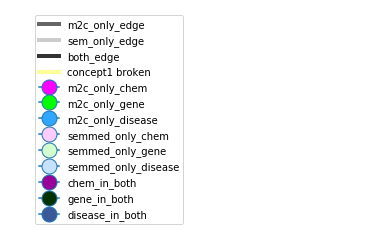

In [6]:
##Legend
edge_colors = {'m2c_only_edge': '#666666', 'sem_only_edge':'#cccccc','both_edge':'#333333','c_1_broken':'#ffff99'}
only_m2c_colors = {'c':'#ff00ff','d':'#31a6ff','g':'#00ff00'}
only_sem_colors = {'c':'#ffccff','d':'#c6e2ff','g':'#d3ffce'}
both_colors = {'c':'#990099','d':'#3b5998','g':'#003300'}

from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='#666666', lw=4, label='m2c_only_edge'),
                   Line2D([0], [0], color='#cccccc', lw=4, label='sem_only_edge'),
                   Line2D([0], [0], color='#333333', lw=4, label='both_edge'),
                   Line2D([0], [0], color='#ffff99', lw=4, label='concept1 broken'),
                   Line2D([0], [0], marker='o', label='m2c_only_chem', markerfacecolor='#ff00ff', markersize=15),
                   Line2D([0], [0], marker='o', label='m2c_only_gene', markerfacecolor='#00ff00', markersize=15),
                   Line2D([0], [0], marker='o', label='m2c_only_disease', markerfacecolor='#31a6ff', markersize=15),
                   Line2D([0], [0], marker='o', label='semmed_only_chem', markerfacecolor='#ffccff', markersize=15),
                   Line2D([0], [0], marker='o', label='semmed_only_gene', markerfacecolor='#d3ffce', markersize=15),
                   Line2D([0], [0], marker='o', label='semmed_only_disease', markerfacecolor='#c6e2ff', markersize=15),
                   Line2D([0], [0], marker='o', label='chem_in_both', markerfacecolor='#990099', markersize=15),
                   Line2D([0], [0], marker='o', label='gene_in_both', markerfacecolor='#003300', markersize=15),
                   Line2D([0], [0], marker='o', label='disease_in_both', markerfacecolor='#3b5998', markersize=15)]

# Create the figure
fig, ax = mplot.subplots()
ax.legend(handles=legend_elements, loc='upper left')
mplot.axis('off')
mplot.show()
